UTS Deep Learning

Nomor 1

Nama: Rio Pramana

NIM: 2440016804

Kelas: LA01

Untuk penjelasan code akan diberikan melalui markdown cell dan comment pada code

**Please only run this if the code block below is executed in Google Colab**

**Otherwise, please ignore this code block below**

In [1]:
# Only run this in Google Colab
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving creditcard.csv to creditcard.csv
User uploaded file "creditcard.csv" with length 36167023 bytes


**Import libraries**

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

# Untuk visualisasi
import seaborn as sns
from matplotlib import pyplot as plt

# Menggunakan pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

Setting random seed dengan tujuan untuk mencoba menghasilkan hasil yang sama (agar hasil memiliki kemungkinan yang lebih tinggi untuk tidak berubah setiap kali code dijalankan sehingga lebih mudah untuk dianalisis)

In [3]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)

# **a. Preprocessing data**

Dataset yang diberikan berupa file .csv mengenai credit card fraud

Kita baca terlebih dahulu datasetnya kemudian simpan di _ds_

In [4]:
# Baca dataset dari file .csv
ds = pd.read_csv('creditcard.csv')

# Tampilkan 5 data awal untuk melihat dataset secara sekilas
ds.head(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,0
4,NaN,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,0


Sebelum melakukan preprocessing, saya lakukan explorasi data secara singkat terlebih dahulu

In [5]:
ds.shape

(284807, 11)

Terdapat 284807 rows of data dan 11 columns

In [6]:
ds.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,Class
count,284802.000000,2.848030e+05,284801.000000,284800.000000,284801.000000,284802.000000,284802.000000,284801.000000,284799.000000,284802.000000,284807.000000
mean,0.000013,7.430608e-07,-0.000028,-0.000011,0.000002,-0.000007,-0.000003,-0.000011,-0.000003,-0.000008,0.001727
std,1.958699,1.651318e+00,1.516254,1.415866,1.380261,1.332276,1.237102,1.194359,1.098643,1.088855,0.041527
min,-56.407510,-7.271573e+01,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,0.000000
25%,-0.920356,-5.985499e-01,-0.890375,-0.848639,-0.691604,-0.768296,-0.554080,-0.208633,-0.643108,-0.535436,0.000000
50%,0.018110,6.546722e-02,0.179832,-0.019848,-0.054332,-0.274204,0.040088,0.022356,-0.051429,-0.092926,0.000000
75%,1.315645,8.037342e-01,1.027167,0.743328,0.611927,0.398558,0.570441,0.327346,0.597152,0.453898,0.000000
max,2.454930,2.205773e+01,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,1.000000


In [7]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284802 non-null  float64
 1   V2      284803 non-null  float64
 2   V3      284801 non-null  float64
 3   V4      284800 non-null  float64
 4   V5      284801 non-null  float64
 5   V6      284802 non-null  float64
 6   V7      284802 non-null  float64
 7   V8      284801 non-null  float64
 8   V9      284799 non-null  float64
 9   V10     284802 non-null  float64
 10  Class   284807 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 23.9 MB


**Missing Values**

Dari hasil ds.info(), terlihat ada masalah **missing values** dari dataset yang diberikan (terdapat columns yang memiliki value null/NaN)

Untuk melihat columns apa saja yang memiliki null/NaN value, kita bisa menjalankan code berikut

In [8]:
ds.isnull().sum()

V1       5
V2       4
V3       6
V4       7
V5       6
V6       5
V7       5
V8       6
V9       8
V10      5
Class    0
dtype: int64

Dari dataset yang diberikan, column V1 sampai V10 (features) memiliki beberapa missing values

Namun, jumlah missing values yang ada pada dataset sangat sedikit jika dibandingkan dengan jumlah data yang ada di dataset sehingga jika dihilangkan tidak akan berpengaruh secara signifikan terhadap model nantinya

Maka, saya memilih untuk tidak memproses data-data yang memiliki null/NaN values

In [9]:
# Drop rows yang memiliki NaN/null
no_null_ds = ds.dropna() #Simpan di no_null_ds

In [10]:
# Mengecek data yang null di no_null_ds
no_null_ds.isnull().sum()

V1       0
V2       0
V3       0
V4       0
V5       0
V6       0
V7       0
V8       0
V9       0
V10      0
Class    0
dtype: int64

In [11]:
no_null_ds.shape

(284758, 11)

Seperti yang dapat dilihat pada cell diatas, sudah tidak ada lagi null values pada dataset yang akan diproses

Jumlah rows of data yang awalnya 284807 berubah menjadi 284758 (berkurang 49 rows of data)

Untuk melakukan preprocessing selanjutnya, saya pisahkan terlebih dahulu dataset menjadi features dan labelsnya (X dan y)

In [12]:
X = no_null_ds[no_null_ds.columns[0:10]].values
y = no_null_ds["Class"].values

In [13]:
print(X.shape, y.shape)

(284758, 10) (284758,)


**Highly imbalanced dataset**

Kita bisa mengecek jumlah Class beserta jumlah data yang belongs to each class dengan .value_counts()

In [14]:
print(no_null_ds["Class"].value_counts())

0    284266
1       492
Name: Class, dtype: int64


In [15]:
no_fraud_ratio = round(100 * (no_null_ds["Class"].value_counts()[0]/len(no_null_ds)), 2)
fraud_ratio = round(100 * (no_null_ds["Class"].value_counts()[1]/len(no_null_ds)), 2)

print("No fraud class ratio: {}%".format(no_fraud_ratio))
print("Fraud class ratio: {}%".format(fraud_ratio))

No fraud class ratio: 99.83%
Fraud class ratio: 0.17%


Dari hasil code diatas, tampak bahwa dataset ini sangat imbalanced karena jumlah class 1 (492) sangat jauh lebih sedikit dibandingkan class 0 (284266) dengan nilai rasio yang sangat jauh

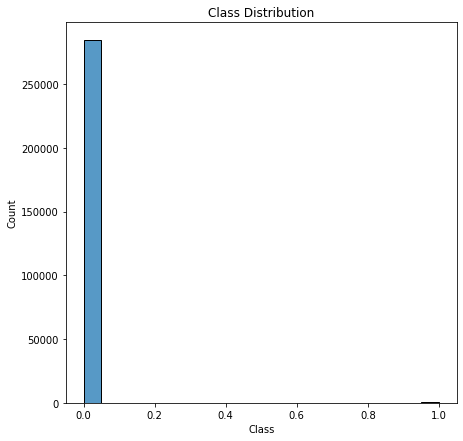

In [16]:
# Visualisasi distribusi class 0 dan 1
plt.figure(figsize=(7,7))
sns.histplot(x='Class', data=no_null_ds)
plt.title('Class Distribution')
plt.show()

Untuk memperbaiki imbalanced dataset, kita dapat melakukan undersampling atau oversampling agar datasetnya menjadi lebih balanced

Untuk **undersampling**, menurut saya tidak cocok untuk diterapkan disini karena beberapa hal:

1. Jika melakukan undersampling (anggap saja undersampling dengan ratio 2:1), akan terdapat huge loss of information karena kita harus mengurangi jumlah data class 0 dengan sangat banyak (> 200 ribu)

2. Dengan melakukan undersampling, jumlah data yang tersisa akan sangat sedikit (mengingat jumlah data class 1 hanya 492 data saja). Hal tersebut sangat tidak cocok untuk **neural network** yang biasanya membutuhkan jumlah data yang banyak

**Oversampling** lebih cocok untuk diterapkan dibandingkan undersampling. Namun, setelah saya melakukan eksperimen menggunakan metode SMOTE untuk oversampling, ternyata hasilnya adalah terjadi overfitting dan metrics F1-score, precision, dan recall menurun drastis dibandingkan dengan dataset yang dibiarkan imbalanced

Setelah membaca beberapa sumber (sumber utama: https://stats.stackexchange.com/questions/357466/are-unbalanced-datasets-problematic-and-how-does-oversampling-purport-to-he) dan melakukan eksperimen, saya menemukan bahwa model mendapatkan hasil yang lebih baik jika tetap menggunakan dataset seperti semula (yang masih imbalanced)

Maka, saya memutuskan untuk tidak melakukan undersampling atau oversampling dan tetap menggunakan dataset original (yang masih imbalanced)

**Outlier detection**

Visualisasikan terlebih dahulu distribusi untuk setiap feature pada X

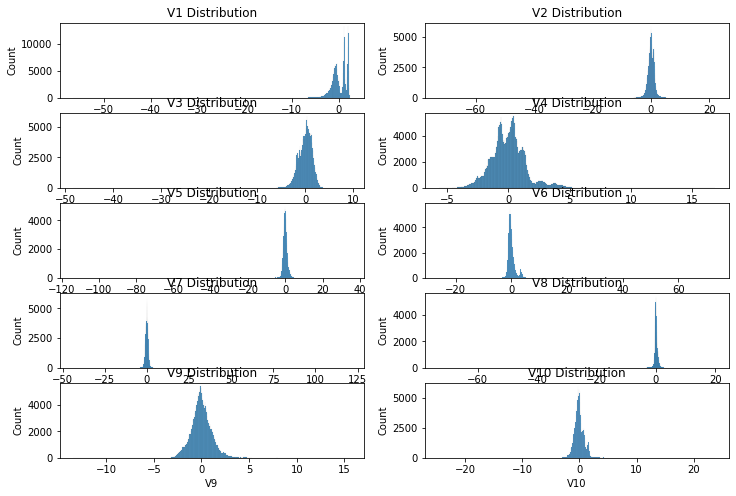

In [17]:
plt.figure(figsize=(12,8))

plt.subplot(521)
sns.histplot(x='V1', data=no_null_ds)
plt.title('V1 Distribution')

plt.subplot(522)
sns.histplot(x='V2', data=no_null_ds)
plt.title('V2 Distribution')

plt.subplot(523)
sns.histplot(x='V3', data=no_null_ds)
plt.title('V3 Distribution')

plt.subplot(524)
sns.histplot(x='V4', data=no_null_ds)
plt.title('V4 Distribution')

plt.subplot(525)
sns.histplot(x='V5', data=no_null_ds)
plt.title('V5 Distribution')

plt.subplot(526)
sns.histplot(x='V6', data=no_null_ds)
plt.title('V6 Distribution')

plt.subplot(527)
sns.histplot(x='V7', data=no_null_ds)
plt.title('V7 Distribution')

plt.subplot(528)
sns.histplot(x='V8', data=no_null_ds)
plt.title('V8 Distribution')

plt.subplot(529)
sns.histplot(x='V9', data=no_null_ds)
plt.title('V9 Distribution')

plt.subplot(5,2,10)
sns.histplot(x='V10', data=no_null_ds)
plt.title('V10 Distribution')

plt.show()

Menurut saya, hasil visualisasi distribusi diatas mengindikasikan adanya kemungkinan terdapat outliers pada dataset ini, seperti pada V1 dan V4

Namun, jika saya melakukan outlier removal, terdapat risiko bahwa data-data yang memiliki ground truth **'Fraud'** juga akan diremove

Hal tersebut dapat menimbulkan masalah karena data yang memiliki class **'Fraud'** sudah sangat sedikit, jika di-remove, dataset ini kemungkinan besar akan semakin imbalanced

(Saya sudah bereksperimen dan mencoba melakukan outliers removal menggunakan IQR method, dan hasilnya benar seperti penjelasan diatas, data 'Fraud' yang awalnya berjumlah 492 berkurang menjadi < 100

Saya menduga bahwa terdapat korelasi yang cukup besar antara data outliers dengan credit card fraud, karena pada kasus credit card fraud, biasanya terjadi hal-hal yang tidak biasa seperti spending yang berlebihan

Maka, saya putuskan untuk tidak melakukan outliers removal)

**Normalization Data**

In [18]:
print("Mean: {}".format(X.mean()))
print("Standard deviation: {}".format(X.std()))
print("Min: {}".format(X.min()))
print("Max: {}".format(X.max()))

Mean: -1.7136620687751606e-05
Standard deviation: 1.4105822501793879
Min: -113.7433067
Max: 120.5894939


Untuk neural networks, akan lebih mudah jika numerical data yang ada pada dataset memiliki mean 0 dan standard deviation 1 (uniform scale)

Sedangkan dataset yang sekarang (seperti pada code diatas) belum memenuhi kondisi tersebut

Maka, kita perlu melakukan normalization pada data X (z-score normalization)

In [19]:
# preprocessing with z-score normalization
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [20]:
print("Mean: {}".format(X.mean()))
print("Standard deviation: {}".format(X.std()))
print("Min: {}".format(X.min()))
print("Max: {}".format(X.max()))

Mean: 9.282334392809237e-19
Standard deviation: 0.9999999999999996
Min: -82.4077116266566
Max: 97.47458991988573


Setelah dataset dinormalisasi, kondisi mean dan standar deviation sudah terpenuhi

mean = 0.0000000000000000009282334392809237 ≈ 0

std = 0.9999999999999996 ≈ 1

**Kesimpulan**

Problem pada dataset dan approach saya:

1. Missing values pada features: dilakukan proses drop data pada rows yang missing

2. Highly imbalanced dataset: Ignored (karena hasilnya jauh lebih baik dibandingkan melakukan oversampling)

3. Outliers: Ignored (karena kebanyakan outliers merupakan data yang classnya 1, jika diremove menyebabkan data class 1 hilang sekitar 80%)

4. Normalization data: dilakukan z-score normalization

# **b. Pisahkan dataset menjadi 80 train, 10 val, 10 test**

Untuk memisahkan dataset, kita menggunakan train_test_split()

Saya pisahkan dulu dataset menjadi 80% train set dan 20% test set

Kemudian, 20% test set tersebut saya bagi 2 untuk validation set sehingga menghasilkan 10% validation set dan 10% test set

**Maka, hasil splitting datasetnya adalah:**

Train = 100% * 0.8 = 80%

Validation = 20% (dari test set) * 0.5 = 10%

Test = 100% * 0.2 * 0.5 = 10%

-----------------------------------------

Jika saya melakukan split train test dengan test size = 0.1, baru kemudian melakukan split train validation dengan test size = 0.1, maka rasio split datasetnya akan menjadi:

Train = 100% * 0.9 * 0.9 = 81%

Validation = 90% (dari train set) * 0.1 = 9%

Test = 100% * 0.1 = 10%

Splitting dengan cara ini tidak menghasilkan rasio yang sesuai dengan yang diminta soal

In [21]:
train_X, remaining_X, train_y, remaining_y = train_test_split(X, y, test_size=0.2)

valid_X, test_X, valid_y, test_y = train_test_split(remaining_X, remaining_y, 
                                                      test_size=0.5)

Print shape setiap data set dan rasio setiap data set:

In [22]:
print(train_y.shape, valid_y.shape, test_y.shape)

training_ratio = round(100 * (train_y.shape[0]/y.shape[0]), 2)
validation_ratio = round(100 * (valid_y.shape[0]/y.shape[0]), 2)
test_ratio = round(100 * (test_y.shape[0]/y.shape[0]), 2)

print("Ratio of training set: {}%".format(training_ratio))
print("Ratio of validation set: {}%".format(validation_ratio))
print("Ratio of test set: {}%".format(test_ratio))

(227806,) (28476,) (28476,)
Ratio of training set: 80.0%
Ratio of validation set: 10.0%
Ratio of test set: 10.0%


Dari hasil code diatas, rasio split dataset sudah benar, yaitu 80-10-10

Kemudian, kita buat class untuk setiap dataset yang akan merubah data menjadi tensor agar dapat diproses oleh model neural networks menggunakan pytorch

In [23]:
class FraudDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __getitem__(self, index):
    X = torch.Tensor(self.X[index])
    y = torch.LongTensor(self.y[index, None])
    
    return X, y

  def __len__(self):
    return len(self.X)

Kemudian, kita gunakan DataLoader dari pytorch untuk menerapkan mini batch learning dengan lebih mudah


Dengan DataLoader, kita bisa membuat mini batches dari dataset kita, kemudian melakukan shuffle data pada setiap epoch (untuk mengurangi overfitting), dan menggunakan multiprocessing dari Python untuk mempercepat data retrieval

Untuk kasus ini, saya menggunakan batch_size = 32 karena dari sumber-sumber yang saya baca di internet, banyak yang menunjukkan bahwa batch_size diatas 16 atau 32 tidak memberikan banyak improvement terhadap model sehingga idealnya menggunakan batch size 16 atau 32

Karena data pada dataset ini cukup banyak, maka saya mencoba menggunakan batch_size = 32 terlebih dahulu

In [24]:
train_ds = FraudDataset(train_X, train_y)
train_loader = DataLoader(train_ds, batch_size=32, 
                             shuffle=True, num_workers=0)
# Shuffle data hanya untuk data training saja

valid_ds = FraudDataset(valid_X, valid_y)
valid_loader = DataLoader(valid_ds, batch_size=32, 
                             shuffle=False, num_workers=0)

test_ds = FraudDataset(test_X, test_y)
test_loader = DataLoader(test_ds, batch_size=32, 
                            shuffle=False, num_workers=0)

# **c. Buat arsitektur Baseline**

Arsitektur baseline memiliki 4 layer (1 input layer, 2 hidden layer, 1 output layer)

Pada method init, terdapat 3 fc yang mendefinisikan keempat layer pada arsitektur, terutama untuk jumlah neuron/nodenya

Kemudian pada method forward, didefinisikan urutan jalannya arsitektur model

In [25]:
n_nodes = 10
num_class = 2

class Baseline(nn.Module):
    def __init__(self):
        super(Baseline, self).__init__()
        # hubungan antara input layer dan hidden layer 1
        self.fc1 = nn.Linear(n_nodes, n_nodes*2)
        # hubungan antara hidden layer 1 dan hidden layer 2
        self.fc2 = nn.Linear(n_nodes*2, n_nodes*2)
        # hubungan antara hidden layer 2 dan output layer
        self.fc3 = nn.Linear(n_nodes*2, num_class)

    def forward(self, X):
        # Setelah setiap layer, gunakan activation function ReLU
        X = self.fc1(X)
        X = F.relu(X)
        X = self.fc2(X)
        X = F.relu(X)
        X = self.fc3(X)

        return X

Kemudian, instantiate modelnya kemudian pilih loss function dan optimizer

Karena loss function dan optimizer tidak ditentukan oleh soal, maka saya akan mencoba menggunakan:

1. Loss Function Cross Entropy, karena cross entropy cocok digunakan untuk kasus classification seperti pada soal nomor 1

2. Optimizer SGD (Stochastic gradient descent), terdapat sumber dari internet yang mengatakan bahwa SGD lebih cocok dibandingkan Adam untuk neural networks yang shallow. Untuk percobaan pertama (baseline), saya akan mencoba SGD terlebih dahulu

In [26]:
baseline_lr = 0.01

# Instantiate baseline model
baseline_model = Baseline()

# Loss function CEL
criterion = nn.CrossEntropyLoss()

# Optimizer SGD dengan learning rate 0.01
optimizer = torch.optim.SGD(baseline_model.parameters(), lr=baseline_lr)

**Training baseline model**

Langkah selanjutnya adalah melakukan training model BPNN

Untuk jumlah epochs, terdapat papers yang menyarankan untuk mencoba jumlah epoch 3 kali lipat dari jumlah features terlebih dahulu

Maka, saya akan menggunakan 30 epochs

In [27]:
epochs = 30
 
train_mean_losses = [] #simpan mean losses training
valid_mean_losses = [] #simpan mean losses validation

valid_best_loss = np.inf # Untuk menyimpan best loss dari validation

for i in range(epochs):  
    #===============================================================
    # training
    train_losses = []
    
    print("=========================================================")
    print("Epoch {}".format(i))
    
    for iter, batch_data in enumerate(train_loader):
        X_batch, y_batch = batch_data
        
        # Set gradient menjadi 0 sebelum melakukan backpropagation
        optimizer.zero_grad()
        
        out = baseline_model(X_batch)
        loss = criterion(out, y_batch.squeeze())
        
        # Lakukan backpropagation
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss)
    
    train_mean_loss = torch.mean(torch.stack(train_losses))
    print('training loss: {:10.8f}'.format(train_mean_loss))
    
    train_mean_losses.append(train_mean_loss)
    
    #===============================================================
    # validation
    valid_losses = []
    with torch.set_grad_enabled(False):
        for iter, batch_data in enumerate(valid_loader):
            X_batch, y_batch = batch_data

            out = baseline_model(X_batch)
            loss = criterion(out, y_batch.squeeze())
            valid_losses.append(loss)
            
        valid_mean_loss = torch.mean(torch.stack(valid_losses))
        print('validation loss: {:10.8f}'.format(valid_mean_loss))
        
        valid_mean_losses.append(valid_mean_loss)
        
        # Jika epoch ini menghasilkan validation loss paling kecil,..
        #.. maka simpan sebagai best model yang akan digunakan
        if valid_mean_loss.cpu().numpy()[()] < valid_best_loss:
            valid_best_loss = valid_mean_loss
            torch.save(baseline_model.state_dict(), "best_model.pth")
            best_epoch = i
    #===============================================================
            

Epoch 0
training loss: 0.03025165
validation loss: 0.00695542
Epoch 1
training loss: 0.00594182
validation loss: 0.00532457
Epoch 2
training loss: 0.00498305
validation loss: 0.00488467
Epoch 3
training loss: 0.00453427
validation loss: 0.00469330
Epoch 4
training loss: 0.00425450
validation loss: 0.00457995
Epoch 5
training loss: 0.00406238
validation loss: 0.00450487
Epoch 6
training loss: 0.00391294
validation loss: 0.00445732
Epoch 7
training loss: 0.00381359
validation loss: 0.00442991
Epoch 8
training loss: 0.00374945
validation loss: 0.00442527
Epoch 9
training loss: 0.00370407
validation loss: 0.00438328
Epoch 10
training loss: 0.00366190
validation loss: 0.00437018
Epoch 11
training loss: 0.00362267
validation loss: 0.00434976
Epoch 12
training loss: 0.00359204
validation loss: 0.00435395
Epoch 13
training loss: 0.00357185
validation loss: 0.00445589
Epoch 14
training loss: 0.00353691
validation loss: 0.00430731
Epoch 15
training loss: 0.00352584
validation loss: 0.00431390
Ep

**Visualisasikan train dan validation loss yang didapat**

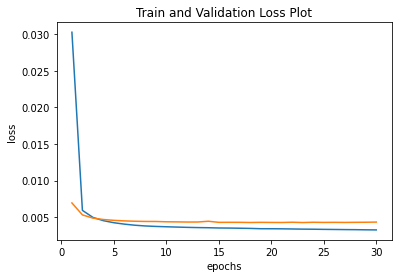

In [28]:
baseline_valid_best_loss = valid_best_loss

with torch.no_grad():
  plt.plot(range(1, epochs+1), train_mean_losses)
  plt.plot(range(1, epochs+1), valid_mean_losses)
  plt.title('Train and Validation Loss Plot')
  plt.xlabel('epochs')
  plt.ylabel('loss')

  plt.show()

Dari hasil training (dan validating) dan visualisasi, terlihat bahwa perbedaan loss bisa dikatakan cukup kecil sehingga model baseline sudah menunjukkan performa yang cukup baik (tanpa overfitting)

Namun, jika dilihat dari visualisasi plot diatas, tampaknya validation loss mulai mengalami kenaikan value ketika mendekati epochs ke-30. Berarti, nilai epochs atau learning rate harus di-tuning agar grafik garis validation lossnya lebih baik (semakin lama nilai validation loss semakin menurun). 

Hal ini biasanya bisa terjadi karena learning rate yang terlalu besar

Menyimpan best model:

In [29]:
baseline_model.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

**Melakukan evaluasi beberapa metrics terhadap model baseline**

Kita analisis performa model baseline terhadap test set:

In [30]:
test_predictions = np.empty((0,2)) # Menyimpan hasil prediksi

with torch.no_grad():
    # Iterasi test set
    for iter, batch_data in enumerate(test_loader):
        X_batch, y_batch = batch_data        
        out = baseline_model(X_batch)
        
        test_predictions = np.append(test_predictions, out.numpy(), 
                                     axis=0)

# Ubah test_predictions agar menjadi kumpulan nilai class hasil prediksinya (0 atau 1)
test_predictions = np.array(test_predictions)
test_predictions = np.argmax(np.array(test_predictions), axis=1)

Selanjutnya, kita print hasil dari performa model baseline ini:

In [31]:
print("=========================================================\n")
print("Predicted Class:")
print(test_predictions)
print("\nGround Truth:")
print(test_y)

print("\n=========================================================\n")
print("Confusion Matrix:")
print(confusion_matrix(test_y, test_predictions))

print("\n=========================================================\n")
baseline_accuracy = accuracy_score(test_y, test_predictions)
print("Accuracy: {}".format(baseline_accuracy))

baseline_f1 = f1_score(test_y, test_predictions, average='macro')
print("F1 Score: ", baseline_f1)

print("\n=========================================================\n")
print("Classification Report:")
print(classification_report(test_y, test_predictions))


Predicted Class:
[0 0 0 ... 0 0 0]

Ground Truth:
[0 0 0 ... 0 0 0]


Confusion Matrix:
[[28425     2]
 [   18    31]]


Accuracy: 0.9992976541649108
F1 Score:  0.8778729408535513


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28427
           1       0.94      0.63      0.76        49

    accuracy                           1.00     28476
   macro avg       0.97      0.82      0.88     28476
weighted avg       1.00      1.00      1.00     28476



# **d. Perbaiki arsitektur model baseline**

Hal pertama yang akan saya ubah dari model baseline adalah jumlah neuron/node pada masing-masing hidden layer. Dari sumber yang saya baca, terdapat beberapa rule yang dapat digunakan untuk menentukan jumlah neuron yang lebih tepat pada setiap hidden layer. Berikut saya kutip:

"*There are many rule-of-thumb methods for determining the correct number of neurons to use in the hidden layers, such as the following:*

*   *The number of hidden neurons should be between the size of the input layer and the size of the output layer.*
*   *The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.*
*   *The number of hidden neurons should be less than twice the size of the input layer.*"

Jumlah neuron yang tepat berdasarkan aturan pertama: antara 2 dan 10

Jumlah neuron yang tepat berdasarkan aturan kedua: 7 + 2 = 9

Jumlah neuron yang tepat berdasarkan aturan ketiga: lebih kecil dari 20

Berdasarkan hasil eksperimen yang saya lakukan, saya menemukan bahwa jumlah neuron = 5 menghasilkan performa yang terbaik (Saya juga telah mencoba jumlah neuron = 3, 7, 9, dan 19)

**Maka, untuk model hasil tuning, saya menggunakan 5 neuron pada setiap hidden layernya**

Berikut adalah class model dengan perubahan jumlah neuron:

In [32]:
new_hidden_neuron = 5

class Modified(nn.Module):
    def __init__(self):
        super(Modified, self).__init__()
        self.fc1 = nn.Linear(n_nodes, new_hidden_neuron)
        self.fc2 = nn.Linear(new_hidden_neuron, new_hidden_neuron)
        self.fc3 = nn.Linear(new_hidden_neuron, num_class)

    def forward(self, X):
        X = self.fc1(X)
        X = F.relu(X)
        X = self.fc2(X)
        X = F.relu(X)
        X = self.fc3(X)

        return X

Untuk activation function pada last layer, lebih cocok menggunakan activation function dengan tipe softmax (untuk classification)

Namun, pada loss function CrossEntropy, terdapat proses-proses yang sudah menerapkan proses softmax tersebut sehingga tidak perlu dinyatakan secara eksplisit lagi pada code function forward()



---
Kemudian, seperti yang terlihat pada visualisasi train dan validation loss untuk model baseline, learning rate yang digunakan tampaknya terlalu besar

Maka, untuk **learning rate pada model modified ini saya perkecil menjadi 0.005** (Saya telah mencoba berbagai learning rate seperti 0.001, 0.0001, 0.003, 0.1, 0.05, 0.01, dan 0.0005, tetapi learning rate = 0.005 menghasilkan performa yang paling baik)


In [149]:
modified_lr = 0.005

# Instantiate modified model
modified_model = Modified()

# Loss function CEL
criterion = nn.CrossEntropyLoss()

# Optimizer SGD dengan learning rate 0.005
optimizer = torch.optim.SGD(modified_model.parameters(), lr=modified_lr)

**Training modified model**

Code yang saya gunakan untuk proses training dan validation modified model sama persis dengan code untuk baseline model (termasuk jumlah epochsnya)

In [150]:
train_mean_losses = [] #simpan mean losses training
valid_mean_losses = [] #simpan mean losses validation

valid_best_loss = np.inf # Untuk menyimpan best loss dari validation

for i in range(epochs):  
    #===============================================================
    # training
    train_losses = []
    
    print("=========================================================")
    print("Epoch {}".format(i))
    
    for iter, batch_data in enumerate(train_loader):
        X_batch, y_batch = batch_data
        
        # Set gradient menjadi 0 sebelum melakukan backpropagation
        optimizer.zero_grad()
        
        out = modified_model(X_batch)
        loss = criterion(out, y_batch.squeeze())
        
        # Lakukan backpropagation
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss)
    
    train_mean_loss = torch.mean(torch.stack(train_losses))
    print('training loss: {:10.8f}'.format(train_mean_loss))
    
    train_mean_losses.append(train_mean_loss)
    
    #===============================================================
    # validation
    valid_losses = []
    with torch.set_grad_enabled(False):
        for iter, batch_data in enumerate(valid_loader):
            X_batch, y_batch = batch_data

            out = modified_model(X_batch)
            loss = criterion(out, y_batch.squeeze())
            valid_losses.append(loss)
            
        valid_mean_loss = torch.mean(torch.stack(valid_losses))
        print('validation loss: {:10.8f}'.format(valid_mean_loss))
        
        valid_mean_losses.append(valid_mean_loss)
        
        # Jika epoch ini menghasilkan validation loss paling kecil,..
        #.. maka simpan sebagai best model yang akan digunakan
        if valid_mean_loss.cpu().numpy()[()] < valid_best_loss:
            valid_best_loss = valid_mean_loss
            torch.save(modified_model.state_dict(), "best_model.pth")
            best_epoch = i
    #===============================================================
            

Epoch 0
training loss: 0.02813078
validation loss: 0.00915222
Epoch 1
training loss: 0.00754281
validation loss: 0.00719676
Epoch 2
training loss: 0.00616469
validation loss: 0.00636039
Epoch 3
training loss: 0.00541861
validation loss: 0.00578165
Epoch 4
training loss: 0.00489841
validation loss: 0.00527931
Epoch 5
training loss: 0.00449109
validation loss: 0.00488161
Epoch 6
training loss: 0.00417714
validation loss: 0.00458748
Epoch 7
training loss: 0.00396655
validation loss: 0.00438123
Epoch 8
training loss: 0.00383636
validation loss: 0.00428926
Epoch 9
training loss: 0.00374106
validation loss: 0.00418810
Epoch 10
training loss: 0.00369933
validation loss: 0.00416944
Epoch 11
training loss: 0.00365189
validation loss: 0.00415245
Epoch 12
training loss: 0.00361596
validation loss: 0.00412002
Epoch 13
training loss: 0.00358539
validation loss: 0.00411568
Epoch 14
training loss: 0.00356321
validation loss: 0.00410347
Epoch 15
training loss: 0.00354020
validation loss: 0.00409042
Ep

**Visualisasikan train dan validation loss yang didapat**

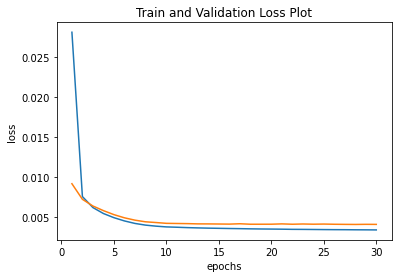

In [151]:
modified_valid_best_loss = valid_best_loss

with torch.no_grad():
  plt.plot(range(1,epochs+1), train_mean_losses)
  plt.plot(range(1,epochs+1), valid_mean_losses)
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.title('Train and Validation Loss Plot')
  plt.show()

Dari hasil visualisasi diatas, tampak bahwa grafik garis validation loss sudah menunjukkan shape yang lebih baik (cenderung menurun ketika epochsnya semakin banyak)

Walaupun tampak meningkat sedikit ketika mendekati epochs 30, tetapi peningkatannya lebih sedikit dibandingkan baseline

Perbedaan training dan validation lossnya juga lebih dekat

Menyimpan best model:

In [152]:
modified_model.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

# **e. Analisis performa dari test set dengan mencari nilai accuracy, precision, recall dan F1-Score**

In [153]:
test_predictions = np.empty((0,2)) # Menyimpan hasil prediksi

with torch.no_grad():
    # Iterasi test set
    for iter, batch_data in enumerate(test_loader):
        X_batch, y_batch = batch_data        
        out = modified_model(X_batch)
        
        test_predictions = np.append(test_predictions, out.numpy(), 
                                     axis=0)

# Ubah test_predictions agar menjadi kumpulan nilai class hasil prediksinya (0 atau 1)
test_predictions = np.array(test_predictions)
test_predictions = np.argmax(np.array(test_predictions), axis=1)

Print hasil evaluasi performa terhadap test set:

In [154]:
print("=========================================================\n")
print("Predicted Class:")
print(test_predictions)
print("\nGround Truth:")
print(test_y)

print("\n=========================================================\n")
print("Confusion Matrix:")
print(confusion_matrix(test_y, test_predictions))

print("\n=========================================================\n")
modified_accuracy = accuracy_score(test_y, test_predictions)
print("Accuracy: {}".format(modified_accuracy))

modified_f1 = f1_score(test_y, test_predictions, average='macro')
print("F1 Score: ", modified_f1)

print("\n=========================================================\n")
print("Classification Report:")
print(classification_report(test_y, test_predictions))


Predicted Class:
[0 0 0 ... 0 0 0]

Ground Truth:
[0 0 0 ... 0 0 0]


Confusion Matrix:
[[28422     5]
 [    9    40]]


Accuracy: 0.9995083579154376
F1 Score:  0.9254088011717134


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28427
           1       0.89      0.82      0.85        49

    accuracy                           1.00     28476
   macro avg       0.94      0.91      0.93     28476
weighted avg       1.00      1.00      1.00     28476



**Analisa (berdasarkan hasil yang saya dapatkan ketika menjalankan code ini)**

**Untuk imbalanced dataset** (terutama yang sangat imbalanced seperti dataset ini), **metric accuracy sebenarnya dapat menjadi misleading**. Seperti yang kita ketahui, class 0 memiliki data sebesar 99,83% dari keseluruhan dataset. Jika kita membuat model yang selalu memprediksi kelas 0, maka kita akan mendapatkan sebuah model dengan akurasi 99,83% juga. Angka tersebut tampak sangat bagus padahal model dengan akurasi tersebut selalu memprediksi class 0 (tanpa ada process apapun)

Itulah sebabnya saat mencoba membuat modified model, **saya lebih berfokus untuk meningkatkan nilai F1-score setinggi mungkin** karena pada imbalanced dataset, nilai precision dan recall jauh lebih berarti dibandingkan accuracy (F1-score merupakan penggabungan dari precision dan recall)


---


Nilai F1-score dari modified model (93%) ini meningkat drastis dibandingkan dengan nilai F1-score dari baseline model (88%)

Terdapat penurunan nilai precision dari baseline model (97%) dibandingkan dengan modified model (94%), tetapi hal ini diimbangi dengan peningkatan yang sangat signifikan pada nilai recallnya (baseline model memiliki recall 82% sedangkan modified model memiliki nilai recall 91%)

Akurasi modified model (99.95%) juga sedikit lebih baik dari akurasi baseline model (99.93%)


---



Classification report baseline model yang saya dapatkan:
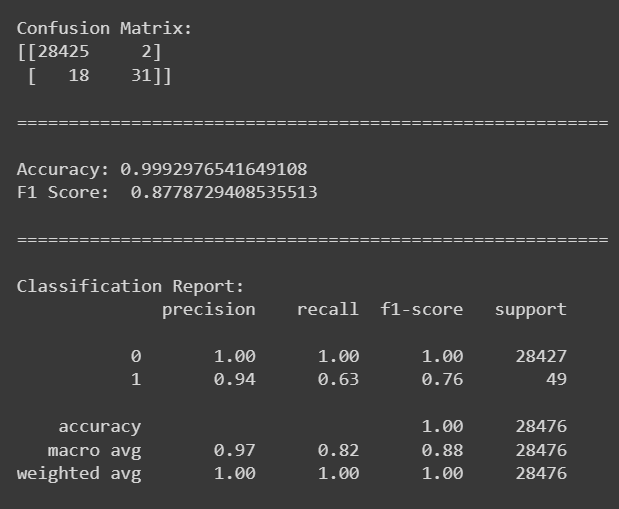

Classification report modified model yang saya dapatkan:
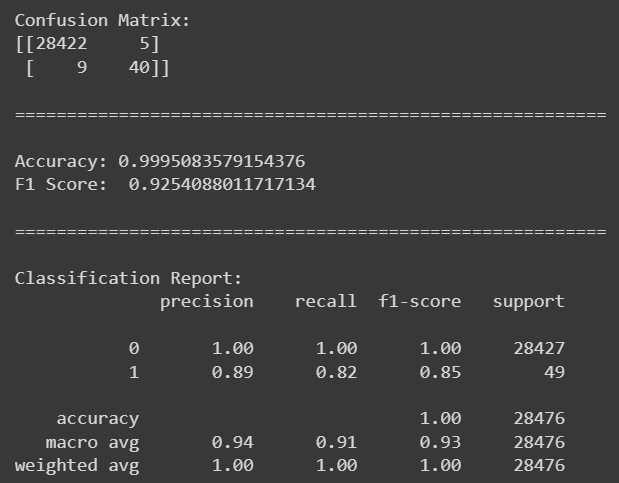

In [155]:
print("Peningkatan akurasi: {}".format(modified_accuracy - baseline_accuracy))
print("Peningkatan F1-score: {}".format(modified_f1 - baseline_f1))

Peningkatan akurasi: 0.00021070375052678614
Peningkatan F1-score: 0.04753586031816215
